In [30]:
import json
import matplotlib.pyplot as plt
import numpy as np


import h5py
from datetime import datetime
import sys
import os
import shutil
import importlib

sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")


import current_measurements.src.src_current_measurement
importlib.reload(current_measurements.src.src_current_measurement);
from current_measurements.src.src_current_measurement import CurrentMeasurementCalibration, generate_ramp_beamsplitter_correlations_filename



import correlation_measurements.src_correlation_measurement
importlib.reload(correlation_measurements.src_correlation_measurement)
from correlation_measurements.src_correlation_measurement import RampOscillationShotsMeasurement, generate_ramp_double_jump_correlations_filename


In [8]:
config_filename = 'current_correlations_config.json'

with open(config_filename, 'r') as f:
    config = json.load(f)

coupling_point = 'coupling_point_2'


coupling_point_config = config[coupling_point]


In [9]:


correlation_pairs = []
for i in range(1, 8):
    for j in range(i + 2, 8):
        correlation_pairs.append(((i, i+1), (j,j+1)))



In [11]:
# configuration_to_measurement = {}


In [12]:


for correlation_pair in correlation_pairs:
    date_code_dict = coupling_point_config['data_config'][str(correlation_pair)]

    year = date_code_dict['year']
    month = date_code_dict['month']
    day = str(date_code_dict['day'])
    hour = date_code_dict['hour']
    minute = date_code_dict['minute']
    second = date_code_dict['second']

    configuration = date_code_dict['configuration']

    filename = generate_ramp_beamsplitter_correlations_filename(year, month, day, hour, minute, second)

    if not configuration in configuration_to_measurement:
        configuration_to_measurement[configuration] = RampOscillationShotsMeasurement(filename)

In [ ]:

# correlation_pair_to_times = {}
# correlation_pair_to_current_correlation = {}
# correlation_pair_to_current_correlation_value = {}

In [14]:
# correlation_pairs = [((1,2),(3,4)),
#                      ((1,2),(4,5))]

# correlation_pairs = [((1,2),(3,4))]

# correlation_pairs = [((1,2),(3,4)),
#                      ((5,6),(7,8))]


for correlation_pair in correlation_pairs:
    configuration = coupling_point_config['data_config'][str(correlation_pair)]['configuration']
    measurement = configuration_to_measurement[configuration]

    readout_pair_1, readout_pair_2 = correlation_pair

    readout_indices_1 = [q - 1 for q in readout_pair_1]
    readout_indices_2 = [q - 1 for q in readout_pair_2]

    times = measurement.get_times()
    current_correlation = measurement.get_covariance_sum_corrected_post_selected(readout_indices_1, readout_indices_2)


    correlation_pair_to_times[correlation_pair] = times
    correlation_pair_to_current_correlation[correlation_pair] = current_correlation


    beamsplitter_time = coupling_point_config['data_config'][str(correlation_pair)]['beamsplitter_time']

    beamsplitter_index = np.argmin(np.abs(times - beamsplitter_time))
    correlation_pair_to_current_correlation_value[correlation_pair] = current_correlation[beamsplitter_index]


    

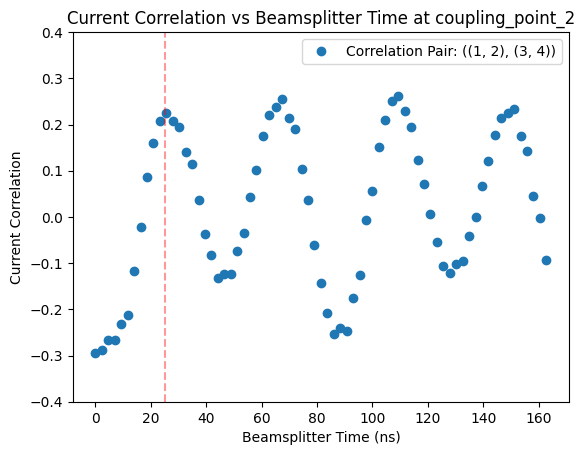

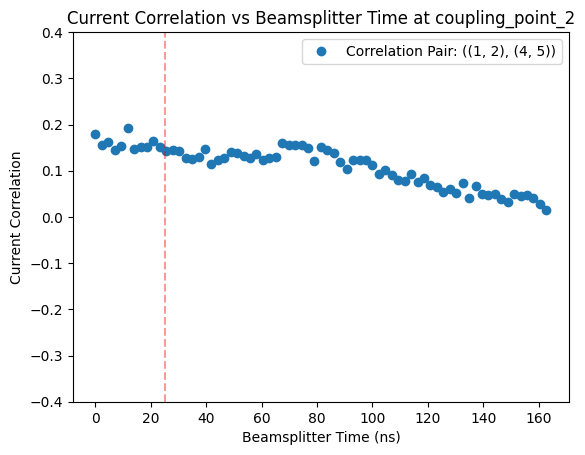

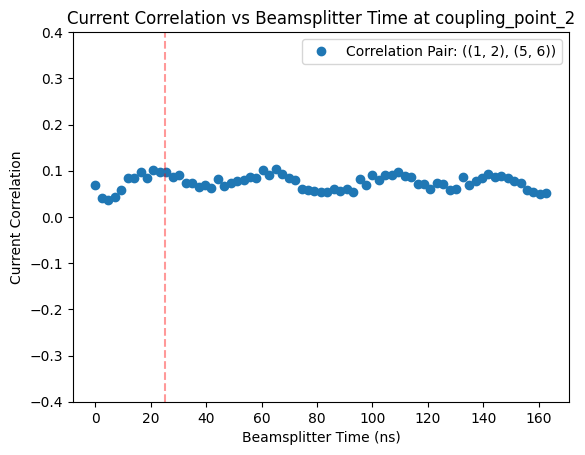

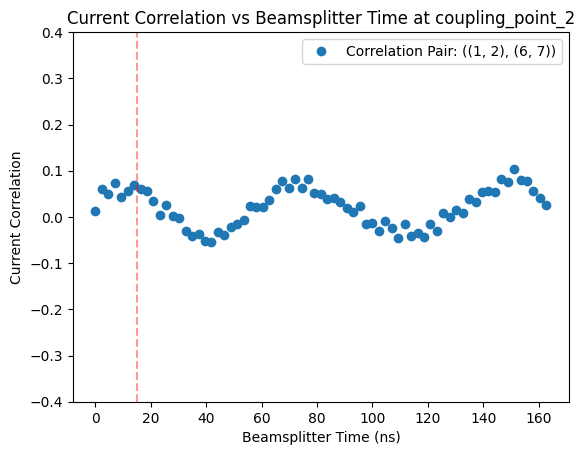

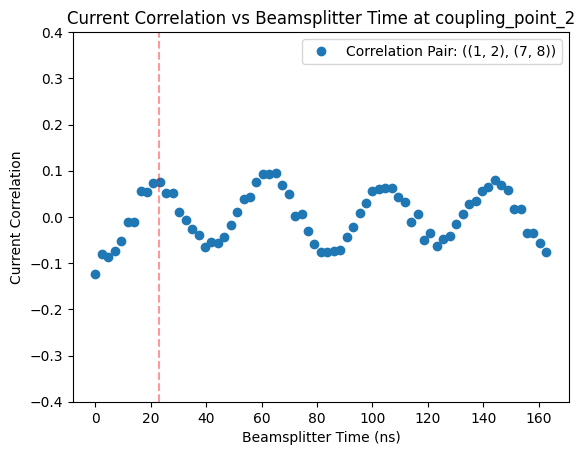

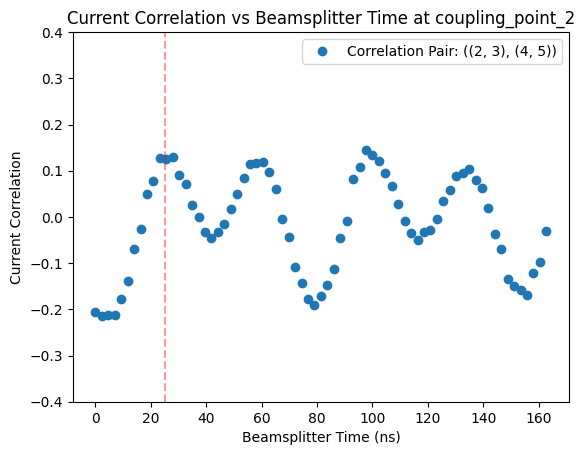

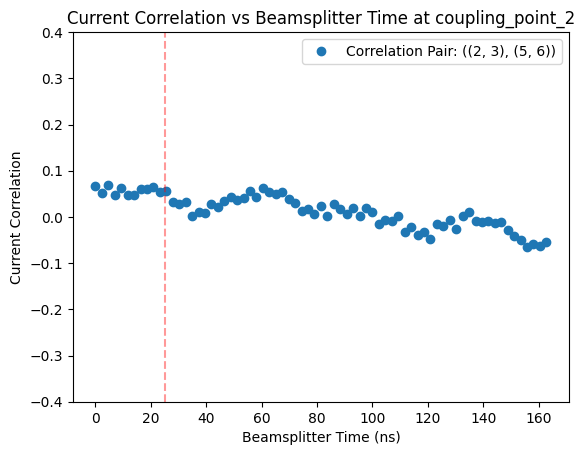

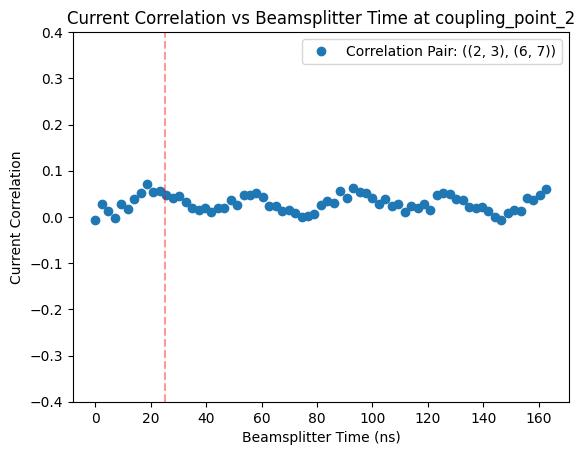

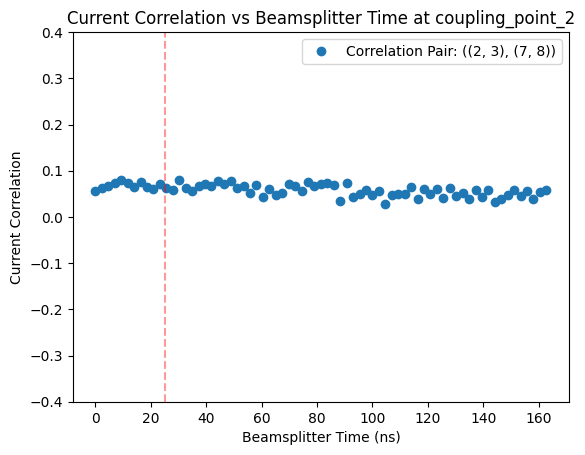

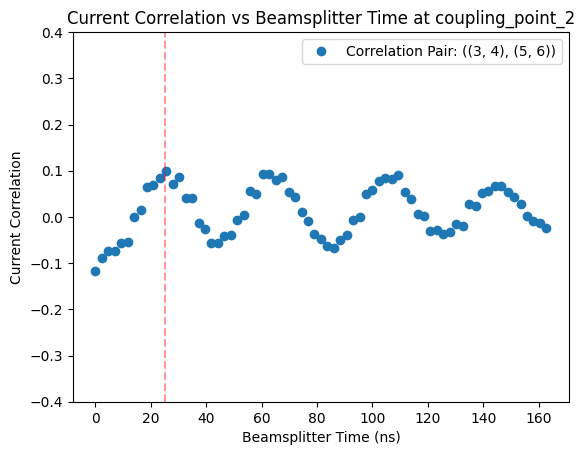

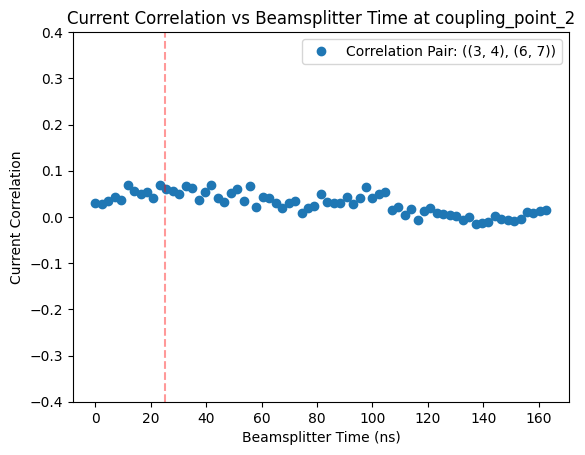

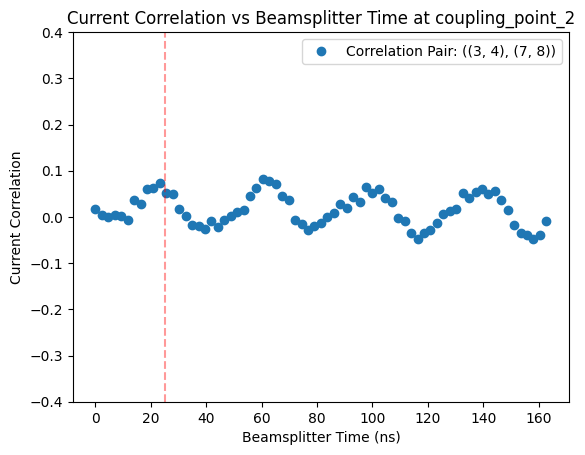

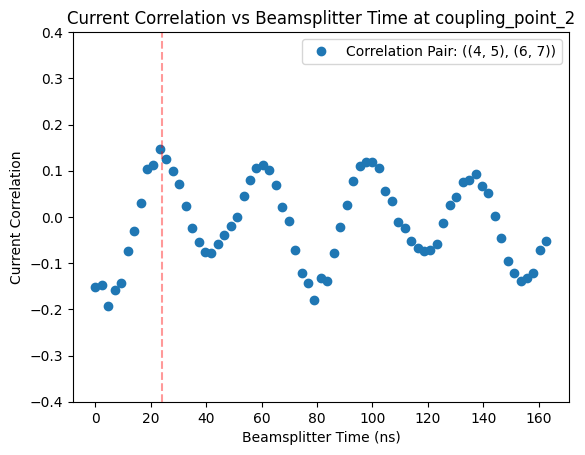

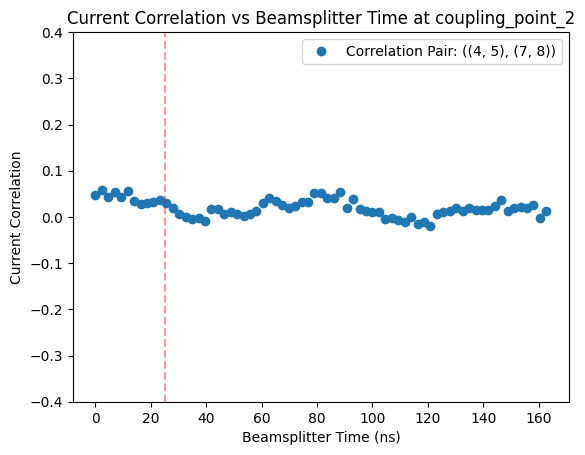

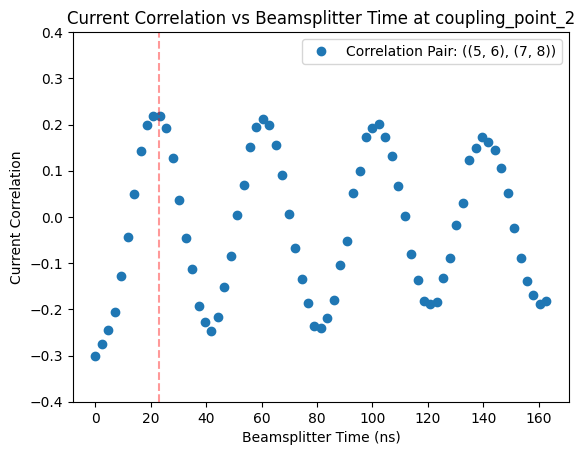

In [15]:
for correlation_pair in correlation_pairs:
    times = correlation_pair_to_times[correlation_pair]

    current_correlation = correlation_pair_to_current_correlation[correlation_pair]

    beamsplitter_time = coupling_point_config['data_config'][str(correlation_pair)]['beamsplitter_time']



    plt.plot(times, current_correlation, linestyle='', marker='o', label=f'Correlation Pair: {correlation_pair}')
    plt.xlabel('Beamsplitter Time (ns)')
    plt.ylabel('Current Correlation')
    plt.title(f'Current Correlation vs Beamsplitter Time at {coupling_point}')

    plt.ylim(-0.4, 0.4)

    plt.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--')

    plt.legend()
    plt.show()
    

{2: [0.22468490753013826, 0.1252500984371328, 0.09989459840890272, 0.14662248562679037, 0.21922055092675877], 3: [0.1416675188761174, 0.05519249272538243, 0.060300526307710406, 0.03100805465503856], 4: [0.09808804147465947, 0.046697913479858966, 0.05276414178545846], 5: [0.06873657364011898, 0.06319873500011114], 6: [0.07611964134008559]}


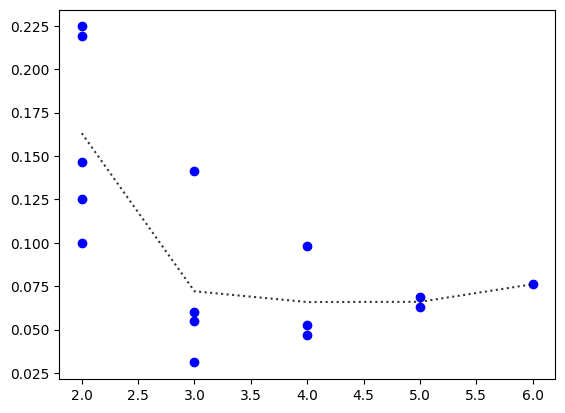

In [16]:
#P# plot current correlations values by distance

distances = list(range(2,7))
distance_to_correlation_value_list = {i: [] for i in distances}

for correlation_pair in correlation_pairs:
    current_correlation_value = correlation_pair_to_current_correlation_value[correlation_pair]

    distance = abs(correlation_pair[0][0] - correlation_pair[1][0])

    distance_to_correlation_value_list[distance].append(current_correlation_value)

print(distance_to_correlation_value_list)


current_correlation_average_values = [np.mean(distance_to_correlation_value_list[distance]) for distance in distance_to_correlation_value_list]


for distance in distances:
    values = distance_to_correlation_value_list[distance]
    plt.scatter([distance]*len(values), values, color='blue')

plt.plot(distances, current_correlation_average_values, linestyle=':', color='black', alpha=0.8)


In [19]:
data_dictionary = {}

for correlation_pair in correlation_pairs:
    data_dictionary[correlation_pair] = {}

    data_dictionary[correlation_pair]['times'] = correlation_pair_to_times[correlation_pair]

    data_dictionary[correlation_pair]['beamsplitter_time'] = coupling_point_config['data_config'][str(correlation_pair)]['beamsplitter_time']

    data_dictionary[correlation_pair]['current_correlation'] = correlation_pair_to_current_correlation[correlation_pair]
    data_dictionary[correlation_pair]['current_correlation_value'] = correlation_pair_to_current_correlation_value[correlation_pair]


In [37]:
def backup_data(data_filename):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename_only = os.path.basename(data_filename)
    name, ext = os.path.splitext(filename_only)
    backup_name = f"{name}_{timestamp}{ext}"
    backup_path = os.path.join('data_backups', backup_name)
    shutil.copy2(data_filename, backup_path)

def save_nested_dict_to_hdf5(filename, data, save_backup=True):

    if save_backup:
        backup_data(filename)

    with h5py.File(filename, 'w') as f:
        def _save_dict(group, dictionary):
            for key, value in dictionary.items():
                if isinstance(value, dict):
                    subgroup = group.create_group(str(key))
                    _save_dict(subgroup, value)
                elif isinstance(value, np.ndarray):
                    group.create_dataset(key, data=value, compression='gzip')
                elif isinstance(value, list):
                    group.create_dataset(key, data=np.array(value), compression='gzip')
                else:
                    group.attrs[key] = value  # Store scalars as attributes
        
        _save_dict(f, data)

def update_data_file(filename, data, keys, save_backup=True):
    if save_backup:
        backup_data(filename)
    
    with h5py.File(filename, 'a') as f:  # Open in append mode
        def _navigate_to_parent(group, key_path):
            """Navigate to the parent group of the target location"""
            current_group = group
            for key in key_path[:-1]:  # All keys except the last one
                if str(key) in current_group:
                    current_group = current_group[str(key)]
                else:
                    # Create the group if it doesn't exist
                    current_group = current_group.create_group(str(key))
            return current_group
        
        def _save_data_at_location(group, key, value):
            """Save data at a specific location, replacing if it exists"""
            # Remove existing data if it exists
            if key in group:
                del group[key]
            
            # Save new data
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                _save_dict(subgroup, value)
            elif isinstance(value, np.ndarray):
                group.create_dataset(key, data=value, compression='gzip')
            elif isinstance(value, list):
                group.create_dataset(key, data=np.array(value), compression='gzip')
            else:
                group.attrs[key] = value  # Store scalars as attributes
        
        def _save_dict(group, dictionary):
            """Helper function to save nested dictionaries"""
            for key, value in dictionary.items():
                _save_data_at_location(group, str(key), value)
        
        # Navigate to the parent location
        parent_group = _navigate_to_parent(f, keys)
        
        # Save the data at the final key location
        final_key = str(keys[-1])
        _save_data_at_location(parent_group, final_key, data)

In [ ]:
# data_filename = 'current_correlations_data.h5'

# this overwrits the whole file !!! be careful
# save_nested_dict_to_hdf5(data_filename, {coupling_point: data_dictionary})

In [38]:
data_filename = 'current_correlations_data.h5'

update_data_file(data_filename, data_dictionary, keys=(coupling_point,), save_backup=True)
